In [1]:
import torch
import tiktoken
from torch.nn import functional as F

In [2]:
computeDevice = torch.device("cpu")
if torch.cuda.is_available():
    computeDevice = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    computeDevice = torch.device("mps")
    
print(f"Using Compute Device: {computeDevice}")

torch.set_float32_matmul_precision("high")

Using Compute Device: mps


In [3]:
enc = tiktoken.get_encoding('gpt2')
with open('input.txt', 'r') as f:
    text = f.read()

print(len(text))
trainText = text[:1000]
tokens = enc.encode(trainText)

B, T = 4, 32
buf = torch.tensor(tokens[:B*T + 1], device=computeDevice)
x = buf[:-1].view(B, T)
y = buf[1:].view(B, T)

print(x.shape)
print(y.shape)

1115394
torch.Size([4, 32])
torch.Size([4, 32])


In [4]:
from train_gpt2 import GPT, GPTConfig
import sys

model = GPT(GPTConfig())
model.to(computeDevice)

if sys.version_info.major == 3 and sys.version_info.minor < 12:
    model = torch.compile(model)
else:
    print(sys.version_info)
    print(f"Cannot compile pytorch model, skipping .....")

sys.version_info(major=3, minor=12, micro=2, releaselevel='final', serial=0)
Cannot compile pytorch model, skipping .....


In [5]:
with torch.no_grad():
    logits, loss = model(x,y)
    print(logits.shape)
    print(loss)

torch.Size([4, 32, 50257])
tensor(10.9181, device='mps:0')


In [6]:
from data_loader import DataLoaderLite

torch.mps.empty_cache()
torch.manual_seed(1337)

# B, T = 16, 1024
B, T = 8, 512
# B, T = 4, 256
dataset = DataLoaderLite(B, T)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
losses = []
for i in range(50):
    optimizer.zero_grad()
    x, y = dataset.next_batch()
    x, y = x.to(computeDevice), y.to(computeDevice)
    if torch.cuda.is_available():
        with torch.autocast(device_type=computeDevice, dtype=torch.bfloat16):
            logits, loss = model(x, y)
    else:
        logits, loss = model(x, y)
    loss.backward()
    optimizer.step()
    print(f"Step {i}, loss: {loss.item()}")
    losses.append(loss.item())


Loaded 338025 tokens
1 epoch = 82 batches


/Users/aj/.pyenv/versions/3.12.2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Step 0, loss: 10.957948684692383
Step 1, loss: 9.534597396850586
Step 2, loss: 9.366049766540527
Step 3, loss: 8.861227035522461
Step 4, loss: 8.649154663085938
Step 5, loss: 8.298532485961914
Step 6, loss: 8.101675987243652
Step 7, loss: 7.852628707885742
Step 8, loss: 7.723637580871582
Step 9, loss: 7.465645790100098
Step 10, loss: 7.46274471282959
Step 11, loss: 7.470012664794922
Step 12, loss: 7.515939712524414
Step 13, loss: 7.453961372375488
Step 14, loss: 7.065621376037598
Step 15, loss: 7.075991153717041
Step 16, loss: 6.921387672424316
Step 17, loss: 6.7503509521484375
Step 18, loss: 6.889780521392822
Step 19, loss: 6.917164325714111
Step 20, loss: 7.096864700317383
Step 21, loss: 6.950870513916016
Step 22, loss: 6.865862846374512
Step 23, loss: 6.95159912109375
Step 24, loss: 6.958200454711914
Step 25, loss: 6.975041389465332
Step 26, loss: 6.8002142906188965
Step 27, loss: 6.859549522399902
Step 28, loss: 6.8856000900268555
Step 29, loss: 6.7339558601379395
Step 30, loss: 6.

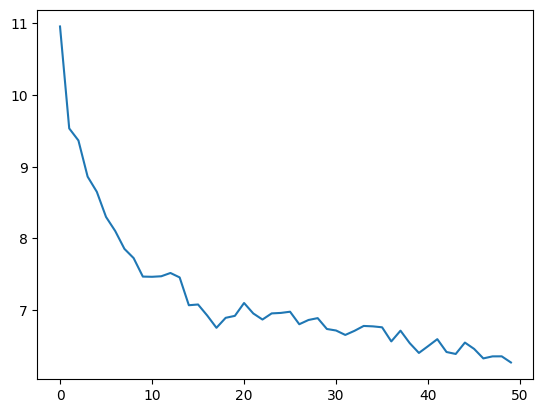

In [7]:
import matplotlib.pyplot as plt

plt.plot(losses)

In [8]:
torch.mps.empty_cache() #GPUPoor

evalText = text[1000:]
evalData = enc.encode(evalText)
B, maxT = 8, 512

x = torch.tensor(evalData[:B * maxT], device=computeDevice)
x = x.view(B, maxT)

# evalText = "Second Citizen:\nWould you proceed especially against Caius Marcius?"
# evalData = enc.encode(evalText)
# x = torch.tensor(evalData, device=computeDevice)
# x = x.view(1, -1)

with torch.no_grad():
    logits, loss = model(x)
    logits = logits[:,-1,:]
    probs = F.softmax(logits, dim=-1)
    # do top-k sampling of 50
    topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
    ix = torch.multinomial(topk_probs, 1) # (B,1)
    xcol = torch.gather(topk_indices, -1, ix)
    x = torch.cat((x, xcol), dim=1)

In [13]:
print(enc.decode(x[0,:-1].tolist()))
print("***" * 10)
for i in range(x.size(0)):
    print("--")
    print(enc.decode([x[i,-1].tolist()]))

Second Citizen:
Would you proceed especially against Caius Marcius?

All:
Against him first: he's a very dog to the commonalty.

Second Citizen:
Consider you what services he has done for his country?

First Citizen:
Very well; and could be content to give him good
report fort, but that he pays himself with being proud.

Second Citizen:
Nay, but speak not maliciously.

First Citizen:
I say unto you, what he hath done famously, he did
it to that end: though soft-conscienced men can be
content to say it was for his country he did it to
please his mother and to be partly proud; which he
is, even till the altitude of his virtue.

Second Citizen:
What he cannot help in his nature, you account a
vice in him. You must in no way say he is covetous.

First Citizen:
If I must not, I need not be barren of accusations;
he hath faults, with surplus, to tire in repetition.
What shouts are these? The other side o' the city
is risen: why stay we prating here? to the Capitol!

All:
Come, come.

First C